# Methods Notebook: Extracting Call Samples for KMeans Clustering

## Imports Section:

In [1]:
import numpy as np
import pandas as pd
import random
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd


import glob
import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [ ]:
import sys

sys.path.append("../src")

In [ ]:
from core import SITE_NAMES, FREQ_GROUPS
import bout.assembly as bt
import bout.clustering as bt_clustering
import bout.plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as dh

import calls.compute_features as cf
import calls.call_extraction as cextract

from cli import get_file_paths

['/Users/adityakrishna/duty-cycle-investigation/daily_notebook', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python311.zip', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/lib-dynload', '', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages', '../src', '../src', '../src', '../src/bout', '../src', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src/bout', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src']


## Function Definitions (most important functions are in `src/`)
### Below are the functions used for plotting and visualization

In [ ]:
def plot_audio_seg(audio_features, spec_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()


def plot_dets_over_audio(audio_features, spec_features, plot_dets):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=3, edgecolor='yellow', facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.ylabel("Frequency (kHz)")
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.xlabel("Time (s)")
    plt.twinx(ax=ax)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.ylabel("Frequency (kHz)")

    plt.show()

In [ ]:
def convert_kaleidoscopedf_to_ravenprodf(df):
    raven_df = pd.DataFrame()
    raven_df['Begin Time (s)'] = df['OFFSET']
    raven_df['End Time (s)'] = df['OFFSET'] + df['DURATION']
    raven_df['Low Freq (Hz)'] = df['Fmin']
    raven_df['High Freq (Hz)'] = df['Fmax']
    raven_df['input_file'] = df['IN FILE']
    raven_df['input_dir'] = df['INDIR']
    raven_df['mean_freq'] = df['Fmean']
    if 'TOP1MATCH*' in df.columns:
        raven_df['TOP1MATCH*'] = df['TOP1MATCH*']
    if 'TOP1MATCH' in df.columns:
        raven_df['TOP1MATCH'] = df['TOP1MATCH']
    raven_df['TOP1DIST'] = df['TOP1DIST']
    raven_df['TOP2MATCH'] = df['TOP2MATCH']
    raven_df['TOP2DIST'] = df['TOP2DIST']
    raven_df['TOP3MATCH'] = df['TOP3MATCH']
    raven_df['TOP3DIST'] = df['TOP3DIST']
    raven_df.sort_values('Begin Time (s)', inplace=True)
    raven_df.insert(0, 'Selection', np.arange(len(raven_df)).astype(int)+1)

    raventxt_df = pd.DataFrame(np.repeat(raven_df.values, 2, axis=0))
    raventxt_df.columns = raven_df.columns
    raventxt_df['Selection'] = raventxt_df['Selection'].astype(int)
    raventxt_df.insert(1, 'Channel', [1]*raventxt_df.shape[0])
    views = np.array(['Waveform 1']*raventxt_df.shape[0], dtype='object')
    views[1::2] = 'Spectrogram 1'
    raventxt_df.insert(1, 'View', views)

    return raventxt_df

def convert_kaleidoscopedf_to_bd2df(df):
    bd2_df = pd.DataFrame()
    bd2_df['start_time'] = df['OFFSET']
    bd2_df['end_time'] = df['OFFSET'] + df['DURATION']
    bd2_df['low_freq'] = df['Fmin']
    bd2_df['high_freq'] = df['Fmax']
    bd2_df['input_file'] = df['IN FILE']
    bd2_df['input_dir'] = df['INDIR']
    bd2_df['mean_freq'] = df['Fmean']
    if 'TOP1MATCH*' in df.columns:
        bd2_df['TOP1MATCH*'] = df['TOP1MATCH*']
    if 'TOP1MATCH' in df.columns:
        bd2_df['TOP1MATCH'] = df['TOP1MATCH']
    bd2_df['TOP1DIST'] = df['TOP1DIST']
    bd2_df['TOP2MATCH'] = df['TOP2MATCH']
    bd2_df['TOP2DIST'] = df['TOP2DIST']
    bd2_df['TOP3MATCH'] = df['TOP3MATCH']
    bd2_df['TOP3DIST'] = df['TOP3DIST']
    bd2_df.sort_values('start_time', inplace=True)
    
    return bd2_df

def convert_raventxtdf_to_bd2df(raventxt_df):
    bd2_human_df = raventxt_df[::2].copy()
    bd2_human_df = bd2_human_df.drop(columns=['Selection', 'View', 'Channel'])
    bd2_human_df.rename(columns={'Begin Time (s)':'start_time',
                                'End Time (s)':'end_time',
                                'Low Freq (Hz)':'low_freq',
                                'High Freq (Hz)':'high_freq'}, inplace=True)
    bd2_human_df.sort_values('start_time', inplace=True)
    
    return bd2_human_df

In [ ]:
wav_filename = '20220730_053000'
site = 'Carp'

In [ ]:
df = pd.read_csv(f'../../Documents/{wav_filename}/output/cluster.csv')
select_df = df[df['IN FILE']==f'{wav_filename}.WAV'].copy()

raventxt_df = convert_kaleidoscopedf_to_ravenprodf(select_df)
raventxt_df.to_csv(f'../../Downloads/kd__{site}_{wav_filename}.txt', sep='\t', index=False)

kaleido_df = pd.read_csv(f'../../Documents/{wav_filename}/output/cluster.csv')
bd2_kaleido_df = convert_kaleidoscopedf_to_bd2df(df)
bd2_kaleido_df

,start_time,end_time,low_freq,high_freq,input_file,input_dir,mean_freq,TOP1MATCH*,TOP1DIST,TOP2MATCH,TOP2DIST,TOP3MATCH,TOP3DIST
0,237.868988,237.870192,26232.047,26756.152,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,26570.713,nocluster,0,NaN,0,NaN,0
1,240.643295,240.645054,24393.871,25565.629,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,25014.352,nocluster,0,NaN,0,NaN,0
2,241.093491,241.094995,26316.930,26845.637,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,26595.945,nocluster,0,NaN,0,NaN,0
3,241.382507,241.384868,26758.547,27789.840,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,27106.775,nocluster,0,NaN,0,NaN,0
4,242.100616,242.102914,23955.531,24692.299,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,24369.277,nocluster,0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,1502.350220,1502.351309,39230.770,41913.539,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,40405.629,nocluster,0,NaN,0,NaN,0
79,1535.820435,1535.825683,17937.580,18563.982,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,18292.221,nocluster,0,NaN,0,NaN,0
80,1536.211670,1536.215410,20408.164,23404.619,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,21388.648,nocluster,0,NaN,0,NaN,0
81,1536.636719,1536.639794,21622.254,23392.613,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,22115.746,nocluster,0,NaN,0,NaN,0


In [ ]:
raventxt_human_df = pd.read_csv(f'../../Documents/Research/mila_files/mila-human-wav-txt/{wav_filename}.txt', sep='\t')
bd2_human_df = convert_raventxtdf_to_bd2df(raventxt_human_df)
bd2_human_df.reset_index(inplace=True, drop=True)
bd2_human_df

,start_time,end_time,low_freq,high_freq,class,class_prob,det_prob,individual,event,input_file,Site name,Recover Folder,SD Card,confidency
0,230.973665,230.986303,24402.235,29229.050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,231.133100,231.150599,24670.391,28156.425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,231.277500,231.289100,25468.000,30247.000,Nyctalus leisleri,0.359,0.592,-1.0,Echolocation,/mnt/ubna_data_01/recover-20220801/UBNA_004/20...,Carp Pond,NaN,NaN,NaN
3,231.651500,231.663500,24609.000,29885.000,Nyctalus leisleri,0.297,0.598,-1.0,Echolocation,/mnt/ubna_data_01/recover-20220801/UBNA_004/20...,Carp Pond,NaN,NaN,NaN
4,231.931500,231.945900,24609.000,29998.000,Nyctalus leisleri,0.340,0.545,-1.0,Echolocation,/mnt/ubna_data_01/recover-20220801/UBNA_004/20...,Carp Pond,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,1636.754878,1636.764600,47195.531,50145.251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
668,1637.438310,1637.462614,42100.559,48804.469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
669,1637.521916,1637.537470,43173.184,49877.095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
670,1637.608500,1637.615800,44375.000,51902.000,Pipistrellus pipistrellus,0.476,0.513,-1.0,Echolocation,/mnt/ubna_data_01/recover-20220801/UBNA_004/20...,Carp Pond,NaN,NaN,NaN


In [ ]:
batdetect2_df = pd.read_csv(f'../data/raw/{site}/bd2__{site}_{wav_filename}.csv', sep=',')
batdetect2_df

,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration
0,231.2775,231.2891,25468.0,30247.0,Echolocation,Nyctalus leisleri,0.359,0.592,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
1,231.6515,231.6635,24609.0,29885.0,Echolocation,Nyctalus leisleri,0.297,0.598,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
2,231.9315,231.9459,24609.0,29998.0,Echolocation,Nyctalus leisleri,0.340,0.545,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
3,232.4015,232.4206,24609.0,29436.0,Echolocation,Nyctalus leisleri,0.309,0.530,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
4,232.7135,232.7302,23750.0,28253.0,Echolocation,Nyctalus leisleri,0.411,0.555,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,1537.3465,1537.3563,20312.0,28303.0,Echolocation,Nyctalus noctula,0.380,0.589,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
340,1537.6905,1537.7014,19453.0,26289.0,Echolocation,Nyctalus noctula,0.438,0.610,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
341,1630.8985,1630.9081,43515.0,49360.0,Echolocation,Pipistrellus pipistrellus,0.317,0.510,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
342,1636.5625,1636.5707,44375.0,57442.0,Echolocation,Pipistrellus pipistrellus,0.538,0.639,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795


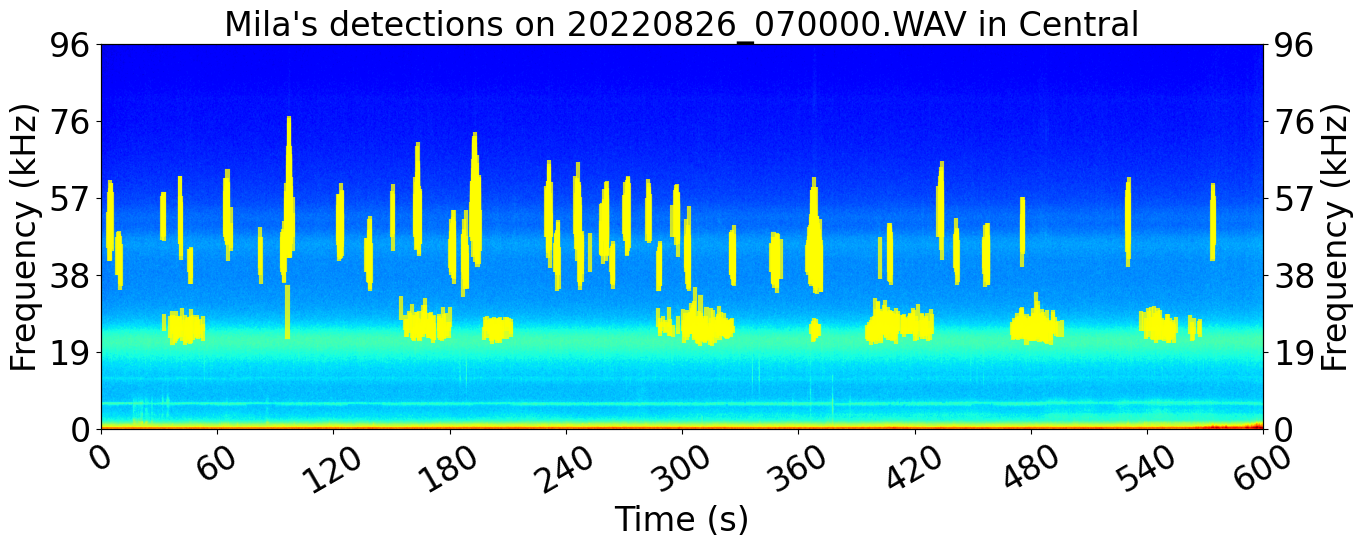

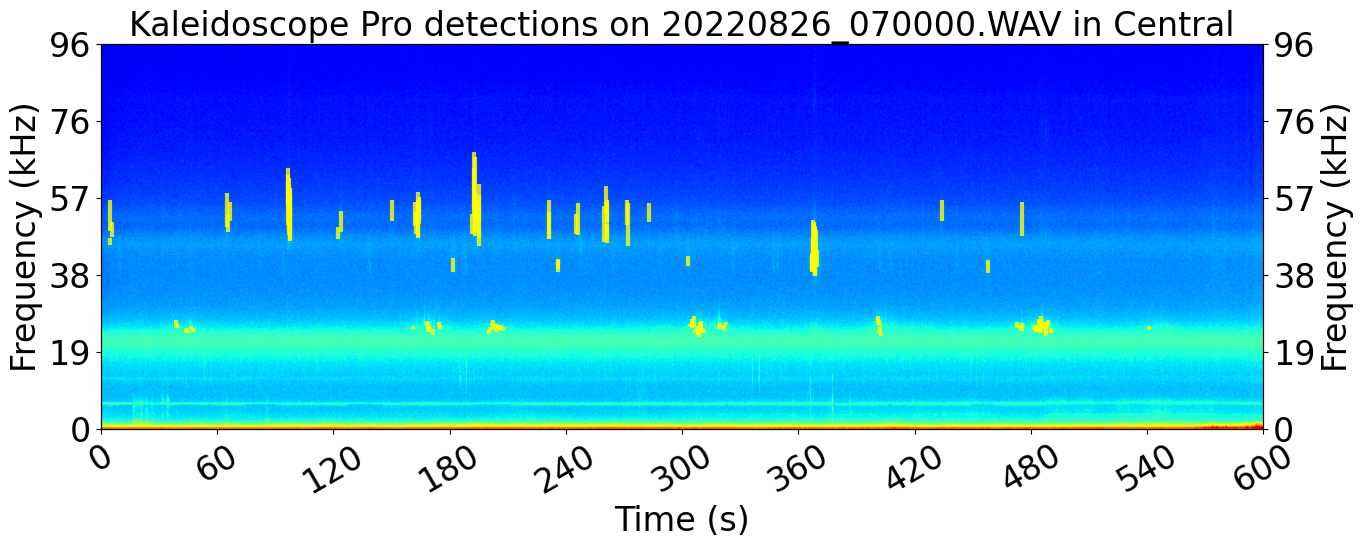

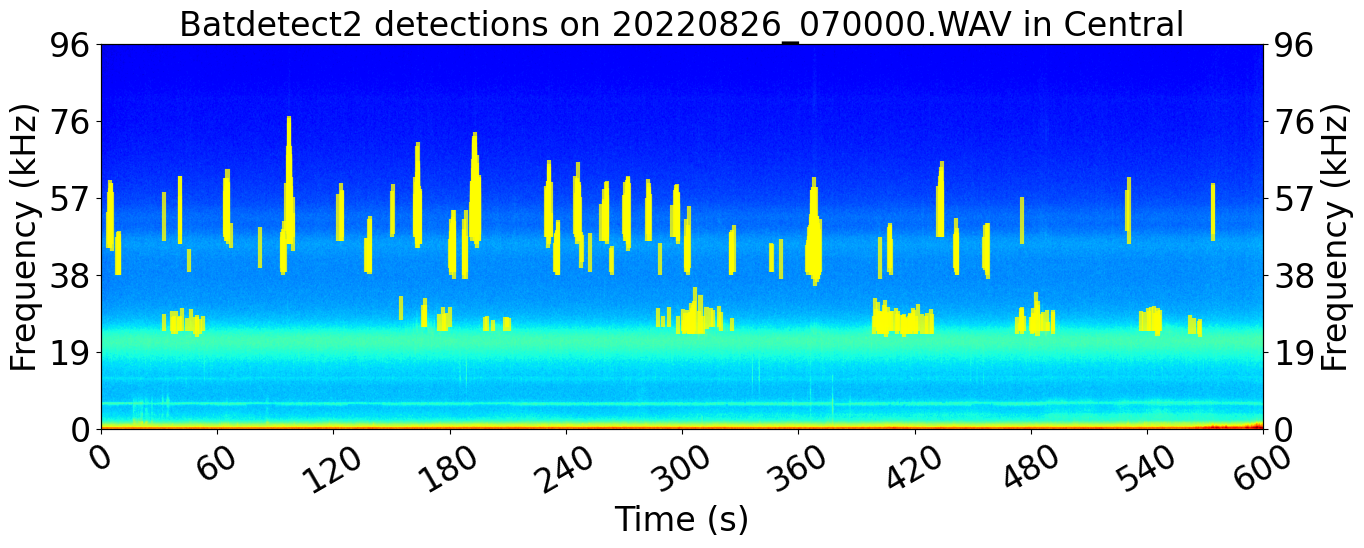

In [ ]:
plot_file = Path(f'../../Documents/{wav_filename}/input/{wav_filename}.WAV')
# Below we filter our detections dataframe to only get the detections corresponding to the above audio file
audio_file = sf.SoundFile(plot_file)
fs = audio_file.samplerate
start = 0
duration = 600
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
lower_dB = -50
upper_dB = 0
vmin = 20*np.log10(np.max(audio_seg)) + lower_dB # hide anything below lower_dB dB
vmax = 20*np.log10(np.max(audio_seg)) + upper_dB # hide anything above upper_dB dB
audio_features = dict()
audio_features['file_path'] = Path(plot_file)
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024 # When segments are short, NFFT should also be small to best see calls (must always be > 128)
spec_features['cmap'] = 'jet' # This colormap shows best contrast between noise and signals
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax

spec_features['plot_title'] = f"Mila's detections on {audio_features['file_path'].name} in {site}"
plot_dets_over_audio(audio_features, spec_features, bd2_human_df)
spec_features['plot_title'] = f"Kaleidoscope Pro detections on {audio_features['file_path'].name} in {site}"
plot_dets_over_audio(audio_features, spec_features, bd2_kaleido_df)
spec_features['plot_title'] = f"Batdetect2 detections on {audio_features['file_path'].name} in {site}"
plot_dets_over_audio(audio_features, spec_features, batdetect2_df)

In [ ]:
def return_confusion_matrix_from_comparing_two_detectors(human_df, machine_df):
    false_positives = 0 ## machine made detection that human did not make
    true_positives = 0  ## machine made detection that human made
    true_negatives = 0  ## machine did not make detection that human also did not make
    false_negatives = 0 ## machine did not make detection that human made
    human_ind = 0
    machine_ind = 0

    while (human_ind < len(human_df))&(machine_ind < len(machine_df)):
        human_det = human_df.iloc[human_ind]

        machine_det = machine_df.iloc[machine_ind]

        machine_det_start_in_human_det_bounds = ((machine_det['start_time']>=human_det['start_time'])&(machine_det['start_time']<=human_det['end_time']))
        machine_det_end_in_human_det_bounds = ((machine_det['end_time']>=human_det['start_time'])&(machine_det['end_time']<=human_det['end_time']))

        if (machine_det_start_in_human_det_bounds|machine_det_end_in_human_det_bounds):
            true_positives += 1
            machine_ind+=1
            human_ind+=1
        else:
            if (machine_det['end_time']<human_det['start_time']):
                false_positives += 1
                machine_ind+=1
            elif (machine_det['start_time']>human_det['end_time']):
                false_negatives += 1
                human_ind+=1
            else:
                true_negatives += 1

    if (machine_ind>len(machine_df)):
        false_negatives += (len(human_df) - (human_ind - 1))
    elif (human_ind>len(human_df)):
        false_positives += (len(machine_df) - (machine_ind - 1))

    return {'true_positives':true_positives, 'false_positives':false_positives, 'false_negatives':false_negatives, 'true_negatives':true_negatives}

## Following the confusion matrix structure shown below

![image](example_confusion_matrix.png)

In [ ]:
return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, bd2_kaleido_df)

{'true_positives': 543,
 'false_positives': 17,
 'false_negatives': 2102,
 'true_negatives': 0}

In [ ]:
return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, batdetect2_df)

{'true_positives': 1597,
 'false_positives': 0,
 'false_negatives': 1060,
 'true_negatives': 0}

In [ ]:
file_sites = {'20220730_053000':'Carp',
 '20220727_083000':'Foliage',
 '20220829_090000':'Foliage',
 '20220826_070000':'Central'}

file_keys = list(file_sites.keys())
file_keys

['20220730_053000', '20220727_083000', '20220829_090000', '20220826_070000']

In [ ]:
kaleido_cf_matrices = {'true_positives':0, 'false_positives':0, 'false_negatives':0, 'true_negatives':0}
batdetect2_cf_matrices = {'true_positives':0, 'false_positives':0, 'false_negatives':0, 'true_negatives':0}

for file_key in file_keys:
    wav_filename = file_key
    site = file_sites[file_key]
    print(wav_filename, site)

    kaleido_df = pd.read_csv(f'../../Documents/{wav_filename}/output/cluster.csv')
    bd2_kaleido_df = convert_kaleidoscopedf_to_bd2df(kaleido_df)

    raventxt_human_df = pd.read_csv(f'../../Documents/Research/mila_files/mila-human-wav-txt/{wav_filename}.txt', sep='\t')
    bd2_human_df = convert_raventxtdf_to_bd2df(raventxt_human_df)
    bd2_human_df.reset_index(inplace=True, drop=True)

    batdetect2_df = pd.read_csv(f'../data/raw/{site}/bd2__{site}_{wav_filename}.csv', sep=',')

    print('Kaleidoscope confusion matrix')
    file_kaleido_cf = return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, bd2_kaleido_df)
    print(file_kaleido_cf)
    kaleido_cf_matrices['true_positives'] += file_kaleido_cf['true_positives']
    kaleido_cf_matrices['false_positives'] += file_kaleido_cf['false_positives']
    kaleido_cf_matrices['false_negatives'] += file_kaleido_cf['false_negatives']
    kaleido_cf_matrices['true_negatives'] += file_kaleido_cf['true_negatives']

    print('Batdetect2 confusion matrix')
    file_batdetect2_cf = return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, batdetect2_df)
    print(file_batdetect2_cf)
    batdetect2_cf_matrices['true_positives'] += file_batdetect2_cf['true_positives']
    batdetect2_cf_matrices['false_positives'] += file_batdetect2_cf['false_positives']
    batdetect2_cf_matrices['false_negatives'] += file_batdetect2_cf['false_negatives']
    batdetect2_cf_matrices['true_negatives'] += file_batdetect2_cf['true_negatives']

20220730_053000 Carp
Kaleidoscope confusion matrix
{'true_positives': 82, 'false_positives': 1, 'false_negatives': 575, 'true_negatives': 0}
Batdetect2 confusion matrix
{'true_positives': 344, 'false_positives': 0, 'false_negatives': 327, 'true_negatives': 0}
20220727_083000 Foliage
Kaleidoscope confusion matrix
{'true_positives': 1, 'false_positives': 0, 'false_negatives': 120, 'true_negatives': 0}
Batdetect2 confusion matrix
{'true_positives': 22, 'false_positives': 1, 'false_negatives': 101, 'true_negatives': 0}
20220829_090000 Foliage
Kaleidoscope confusion matrix
{'true_positives': 19, 'false_positives': 0, 'false_negatives': 42, 'true_negatives': 0}
Batdetect2 confusion matrix
{'true_positives': 38, 'false_positives': 0, 'false_negatives': 73, 'true_negatives': 0}
20220826_070000 Central
Kaleidoscope confusion matrix
{'true_positives': 543, 'false_positives': 17, 'false_negatives': 2102, 'true_negatives': 0}
Batdetect2 confusion matrix
{'true_positives': 1597, 'false_positives': 

In [ ]:
kaleido_cf_matrices

{'true_positives': 645,
 'false_positives': 18,
 'false_negatives': 2839,
 'true_negatives': 0}

In [ ]:
batdetect2_cf_matrices

{'true_positives': 2001,
 'false_positives': 1,
 'false_negatives': 1561,
 'true_negatives': 0}